## Data Preprocessing

In this notebook, let's practice the regular data preprocessing techniques.

**The regular steps for data preprocessing are:**
1. removing missing value, removing duplicates, split_train_test, imputation, encoding categorical features and labels, scaling features, feature selection or extraction
2. sometimes you may also split_train_test after imputation, encoding and scaling, but it's the best practice to split dataset beforehand, as it will avoid data leakage.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import  pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/refs/heads/master/penguins.csv')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [3]:
df.info() # check data type, missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [4]:
df.describe() # check the statistics to see any outilers and extreme scales

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


### Identify missing values

In [5]:
df.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

<Axes: >

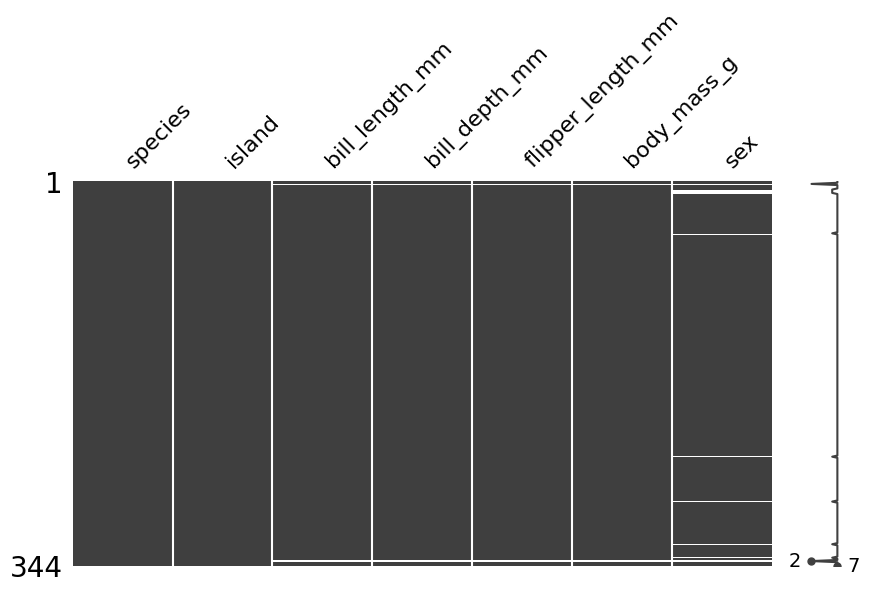

In [7]:
# Visualize the missing value with missingno
# https://github.com/ResidentMario/missingno
import missingno as msno
msno.matrix(df, figsize=(10,5))


<Axes: >

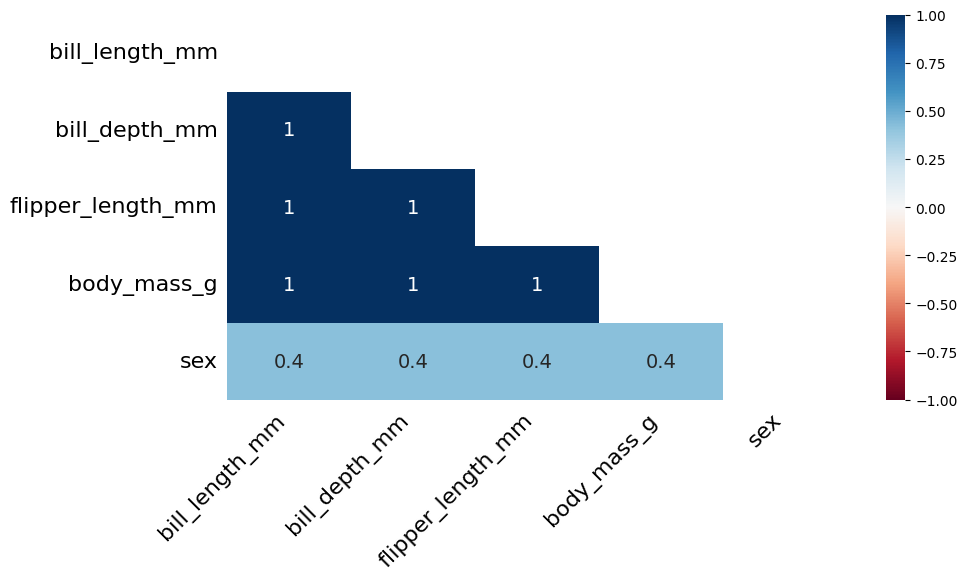

In [8]:
# missingno correlation heatmap measures nullity correlation:
# how strongly the presence or absence of one variable affects the presence of another
msno.heatmap(df, figsize=(10,5))

Since the percentage of missing values is less than 5%, it's best to impute than dropping missing value.

### Split the dataset

Split the dataset after removal of missing values and duplicates. The splitting go before othe types of data preprocessing.

In [9]:
# Split the dataset into train and test set
X = df.drop('species', axis=1)
y = df['species']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create Pipelines for Numeric and Categorical separately

- num: impute, standardize
- cat: impute, one-hot-encoding

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [11]:
# Identify numeric and categorical columns
num_cols = X_train.select_dtypes(include=np.number).columns
cat_cols = X_train.select_dtypes(include='object').columns


In [12]:
# Create transformers for numeric
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


In [13]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop = 'first'))
])

In [14]:
# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

# Apply transformations
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [15]:
# Get the feature names after OneHotEncoding
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)

# Combine numerical and categorical feature names
all_feature_names = num_cols.tolist() + cat_feature_names.tolist()

# Convert back to DataFrame
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)


In [16]:
X_train_processed_df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_MALE
0,-1.517846,-0.437373,-0.433589,-1.064468,0.0,0.0,0.0
1,0.539212,-0.842410,0.970707,1.181983,0.0,0.0,1.0
2,-0.844296,1.284033,-0.433589,0.589170,0.0,1.0,1.0
3,-0.662255,0.018293,-0.574019,-1.002067,1.0,0.0,0.0
4,0.957905,-1.044928,1.883499,1.618794,0.0,0.0,1.0


In [17]:
# Encode the label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [18]:
y_train[:10]

array([0, 2, 0, 0, 2, 2, 2, 0, 0, 0])

### Features Scaling

### Features Selection

1.Pairplot & corr matrix  
2.L1 regularization (L2 is used to prevent shrink features and avoid overfitting, not for feature selection (i.e. zero out features)）  
3.Sequential Backward Selection  
4.Random Forest, find feature importances  

#### Pairplot & Corr Matrix

In [19]:
# To make it simple, we consider only numeric features, excl. encoded features

X_train_fs = X_train_processed_df[num_cols]
X_test_fs = X_test_processed_df[num_cols]

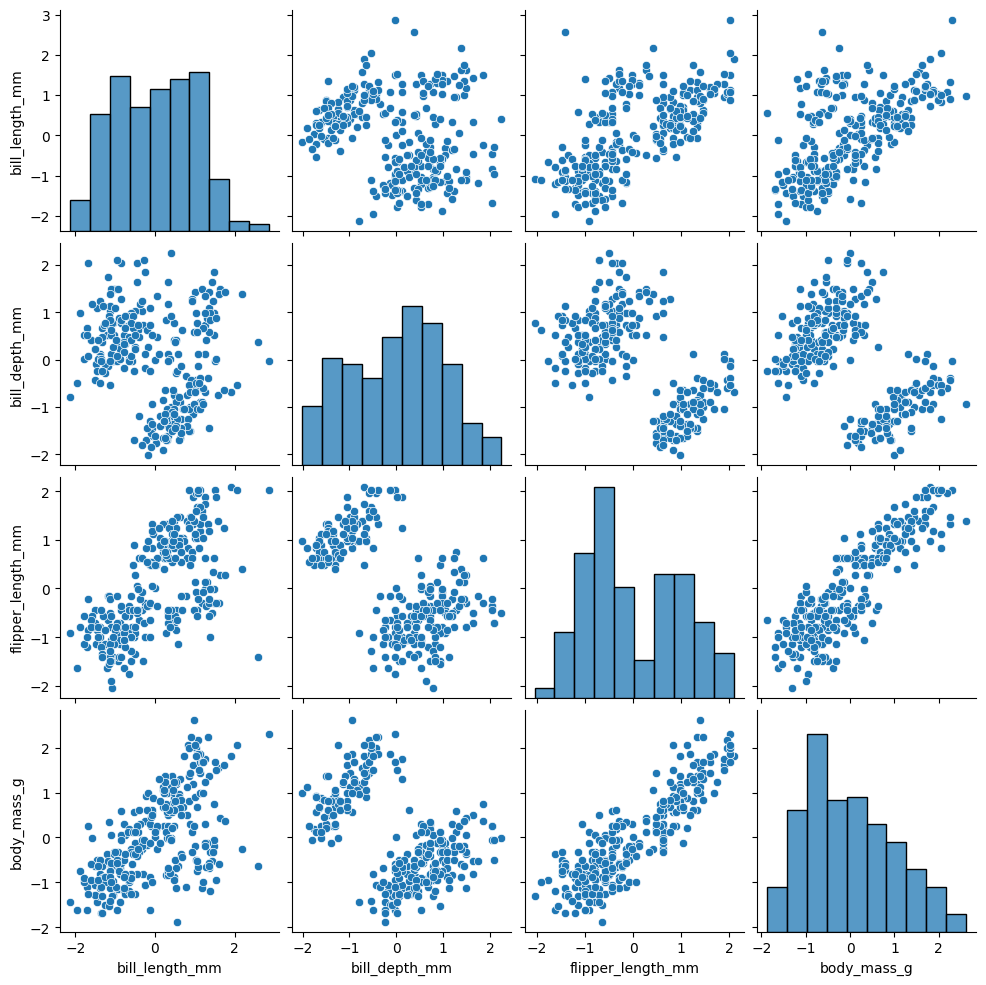

In [20]:
# Use seaborn pairplot to visualize the correlation of feature pairs
sns.pairplot(X_train_fs)


<Axes: >

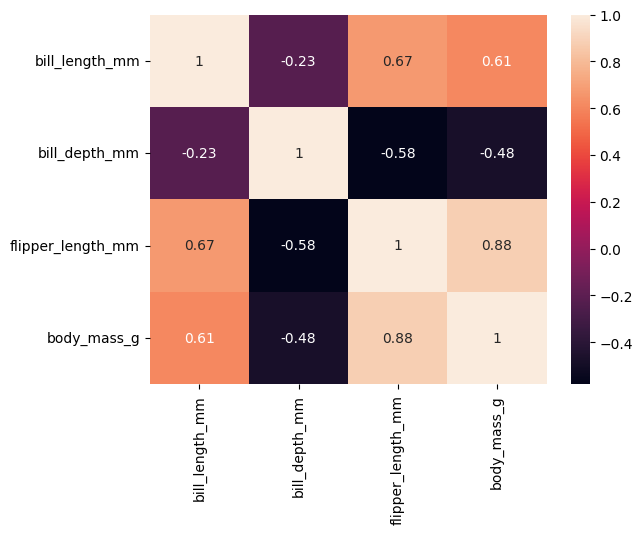

In [21]:
# Use the corr_matrix = df.corr() to calculate the corr
# Visual the corr matrix sns.heatmap(corr_matrix, annot=True)
corr_matrix = X_train_fs.corr()
sns.heatmap(corr_matrix, annot=True)


body_mass is highly correlated with flipper_length and bill_length. body_mass can be dropped for redundancy. Let's explore further with L1 regularizatioin.

#### L1 Regularization

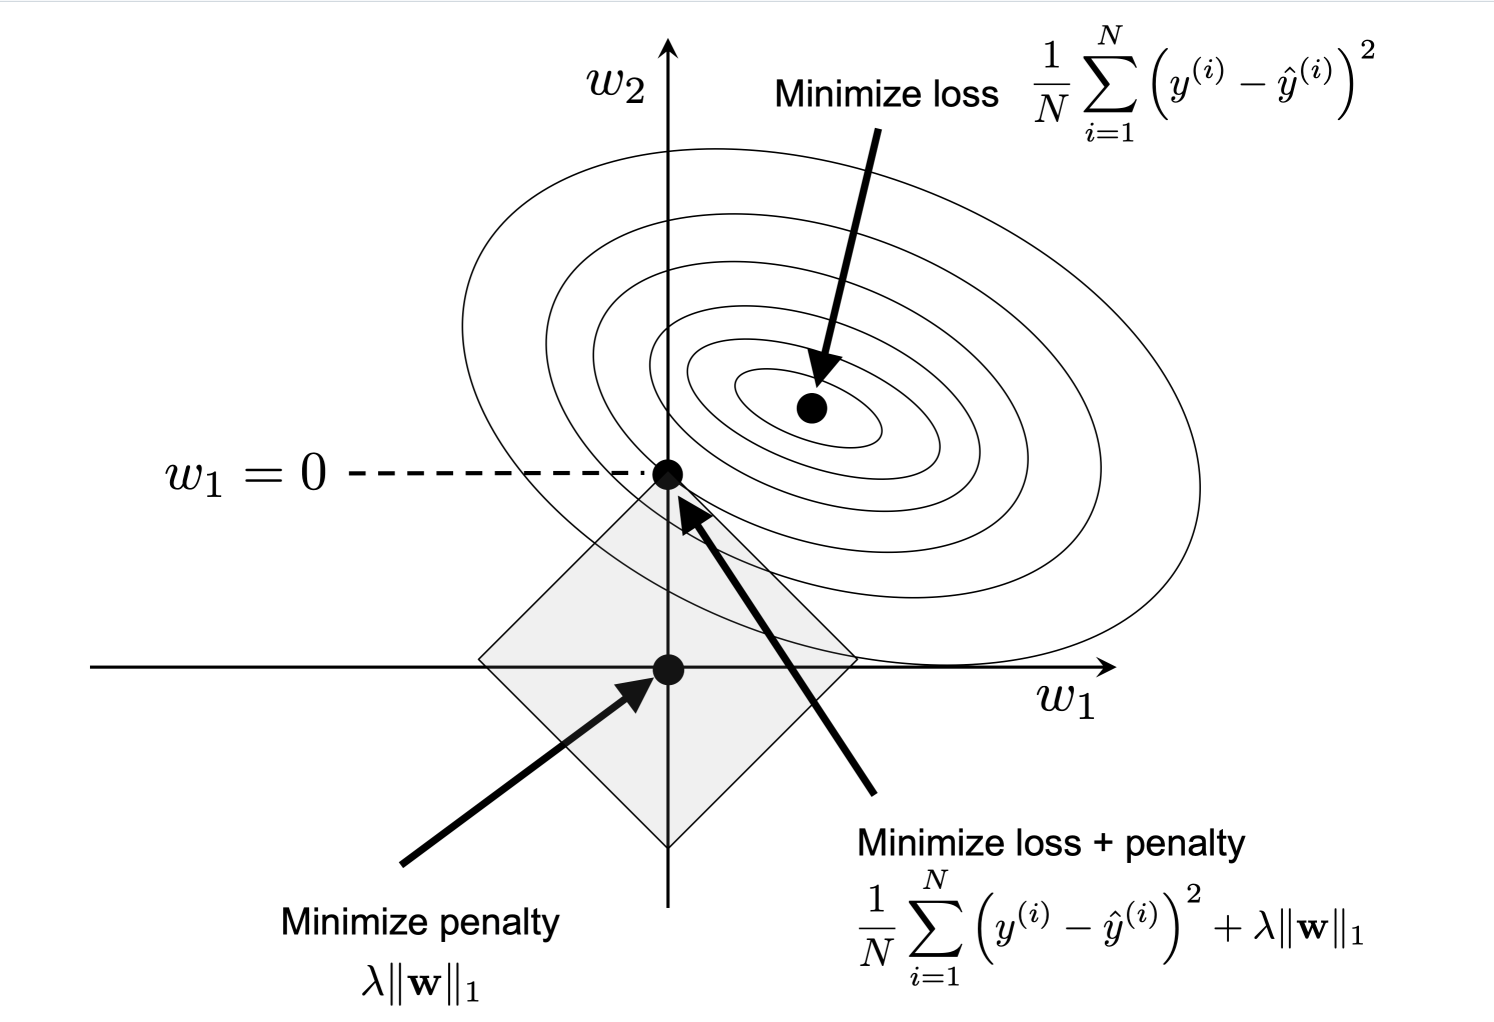

In [22]:
# Logistic Regression with L1
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', multi_class='ovr')
# Note that C=1.0 is the default. You can increase or decrease it to make the regulariztion effect weaker or stronger, respectively.

lr.fit(X_train_fs, y_train)
print('Training accuracy:', lr.score(X_train_fs.iloc[:,:4], y_train))
print('Test accuracy:', lr.score(X_test_fs, y_test))


Training accuracy: 0.9963636363636363
Test accuracy: 0.9710144927536232


c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [23]:
X_train_fs.columns

Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], dtype='object')

In [24]:
lr.coef_

array([[-6.17875633,  2.83086565,  0.        ,  0.59668263],
       [ 5.49982231,  0.37550846, -0.45626952, -4.60244965],
       [ 0.        , -3.14002919,  1.70792627,  2.00991815]])

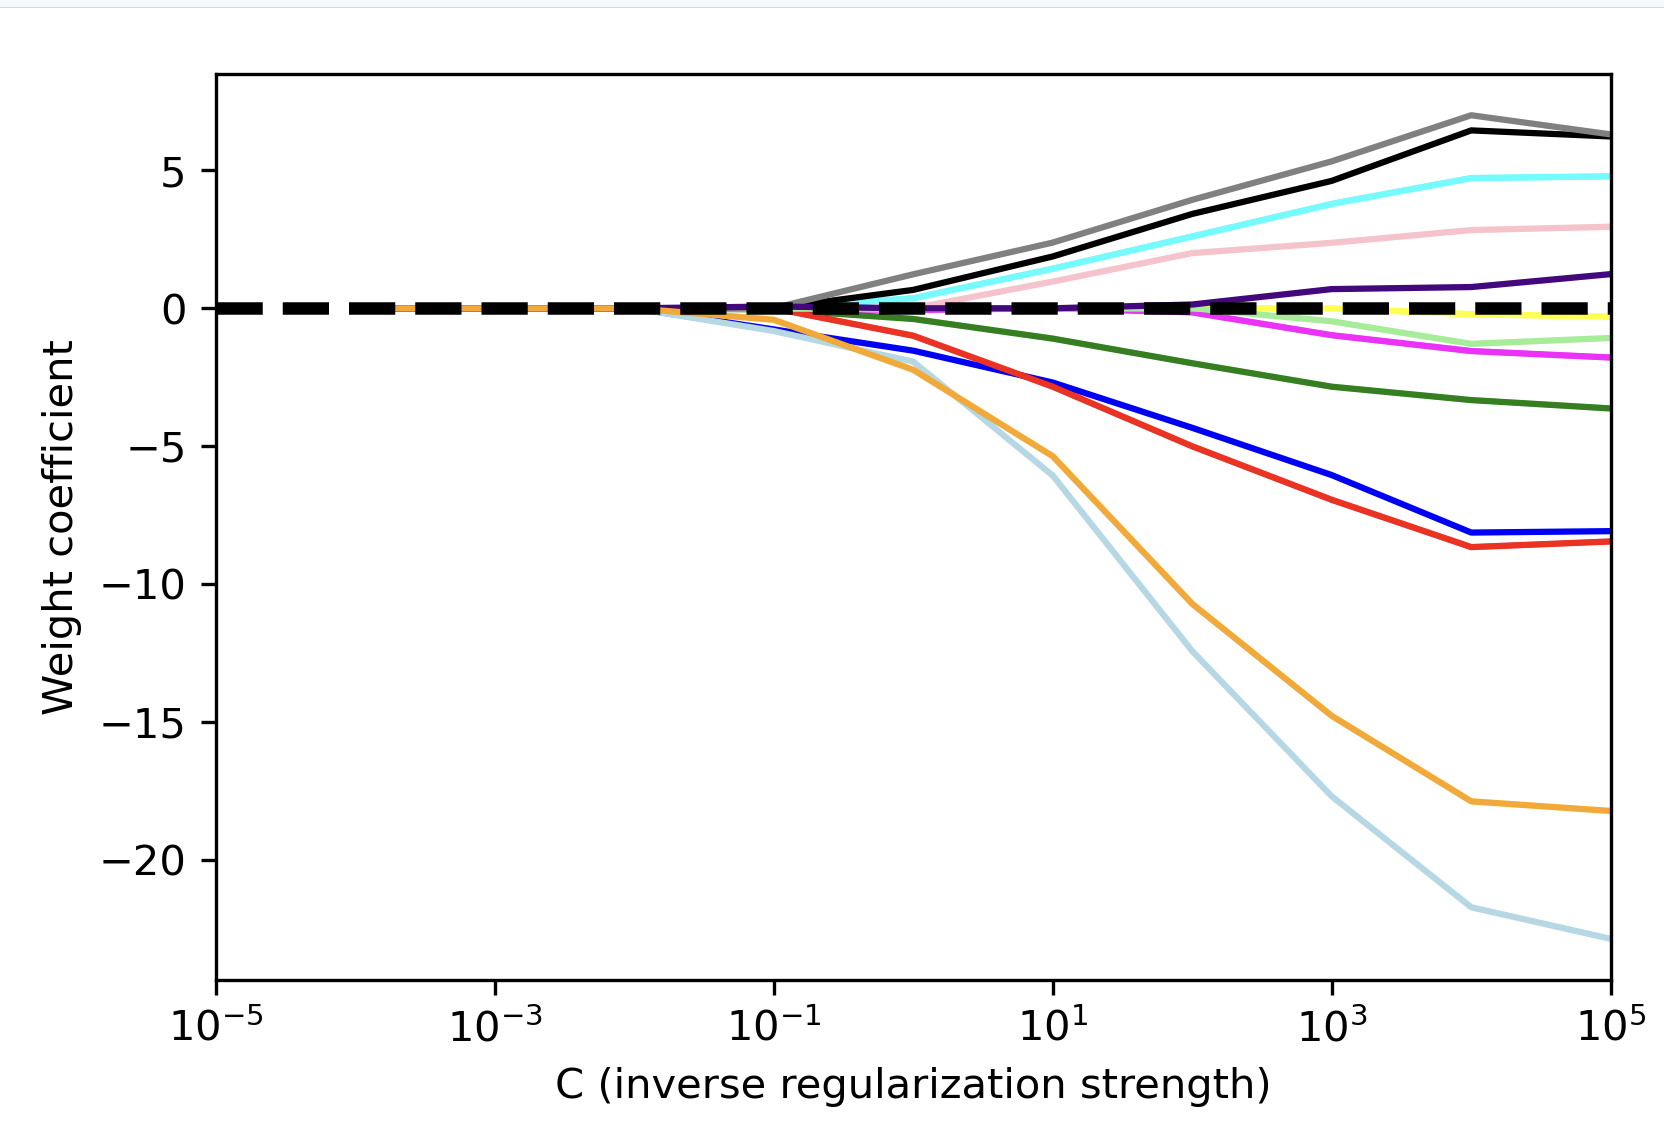

### Sequential Backward Selection (SBS)

L1 is used for regularized models only. For unregularized models, such as KNN, Decision Tree, etc, use SBS as an alternative.

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_fs, y_train)

KNeighborsClassifier()

In [26]:
from sklearn.feature_selection import SequentialFeatureSelector

# Create a Sequential Backward Selection (SBS) object
sbs = SequentialFeatureSelector(
    knn,
    n_features_to_select='auto',  # Automatically select the best number of features
    direction='backward',
    scoring='accuracy',  # Or any other suitable scoring metric
    cv=5  # Number of cross-validation folds
)

# Fit the SBS object to the data
sbs.fit(X_train_fs, y_train)


SequentialFeatureSelector(direction='backward',
                          estimator=KNeighborsClassifier(), scoring='accuracy')

In [27]:
# Get the selected feature indices
selected_feature_indices = sbs.get_support(indices=True)

# Get the selected feature names
selected_feature_names = X_train_fs.columns[selected_feature_indices]


In [28]:
# Print the selected feature names
print("Selected Features:")
print(selected_feature_names)

# Optionally, transform the data to use only the selected features
X_train_fs_selected = sbs.transform(X_train_fs)


Selected Features:
Index(['bill_length_mm', 'bill_depth_mm'], dtype='object')


### Random Forest

Use random forest to rank the features by importances, then choose a subset of features for modeling training

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust parameters as needed

# Fit the Random Forest model to the data
rf.fit(X_train_fs, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to display feature names and importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train_fs.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
             Feature  Importance
0     bill_length_mm    0.415516
2  flipper_length_mm    0.300705
1      bill_depth_mm    0.198745
3        body_mass_g    0.085034


## Homework

- Step1: Practice Data Preprocessing on a raw dataset, which should include missing values, numeric and categorical features, so you can attemp imputation, encoding and scaling. You don't have to go over all steps. Please consider the cleaness of your dataset.
- Step2: After above process, you may perform feature selections. You may attemp L1 regularization, SBS, random forest, etc. You don't have to try all methods but just play around and find one that you feel comfortable with.

You can find medium-size raw dataset on Kaggle.com or NYCOpenData. Or you may use the Used Car dataset below.

Used Car Dataset  
https://www.kaggle.com/datasets/alikalwar/uae-used-car-prices-and-features-10k-listings

**Please submit your notebook by 3/9 11:59 pm to BrightSpace.**

In [36]:
used_cars=pd.read_csv('uae_used_cars_10k.csv')
used_cars.head()

,Make,Model,Year,Price,Mileage,Body Type,Cylinders,Transmission,Fuel Type,Color,Location,Description
0,toyota,camry,2016,47819,156500,Sedan,4,Automatic Transmission,Gasoline,Black,Dubai,"2016 toyota camry with Rear camera, Leather se..."
1,kia,sorento,2013,61250,169543,SUV,4,Automatic Transmission,Gasoline,Grey,Abu Dhabi,"2013 kia sorento with Sunroof, Adaptive cruise..."
2,mini,cooper,2023,31861,221583,Soft Top Convertible,4,Automatic Transmission,Gasoline,Grey,Dubai,"2023 mini cooper with Adaptive cruise control,..."
3,nissan,altima,2016,110322,69754,Sedan,4,Automatic Transmission,Gasoline,Red,Dubai,"2016 nissan altima with Rear camera, Adaptive ..."
4,toyota,land-cruiser-76-series,2020,139994,71399,Pick Up Truck,4,Manual Transmission,Gasoline,White,Dubai,2020 toyota land-cruiser-76-series with Adapti...


In [37]:
used_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Make          10000 non-null  object
 1   Model         10000 non-null  object
 2   Year          10000 non-null  int64 
 3   Price         10000 non-null  int64 
 4   Mileage       10000 non-null  int64 
 5   Body Type     10000 non-null  object
 6   Cylinders     9895 non-null   object
 7   Transmission  10000 non-null  object
 8   Fuel Type     10000 non-null  object
 9   Color         10000 non-null  object
 10  Location      10000 non-null  object
 11  Description   10000 non-null  object
dtypes: int64(3), object(9)
memory usage: 937.6+ KB


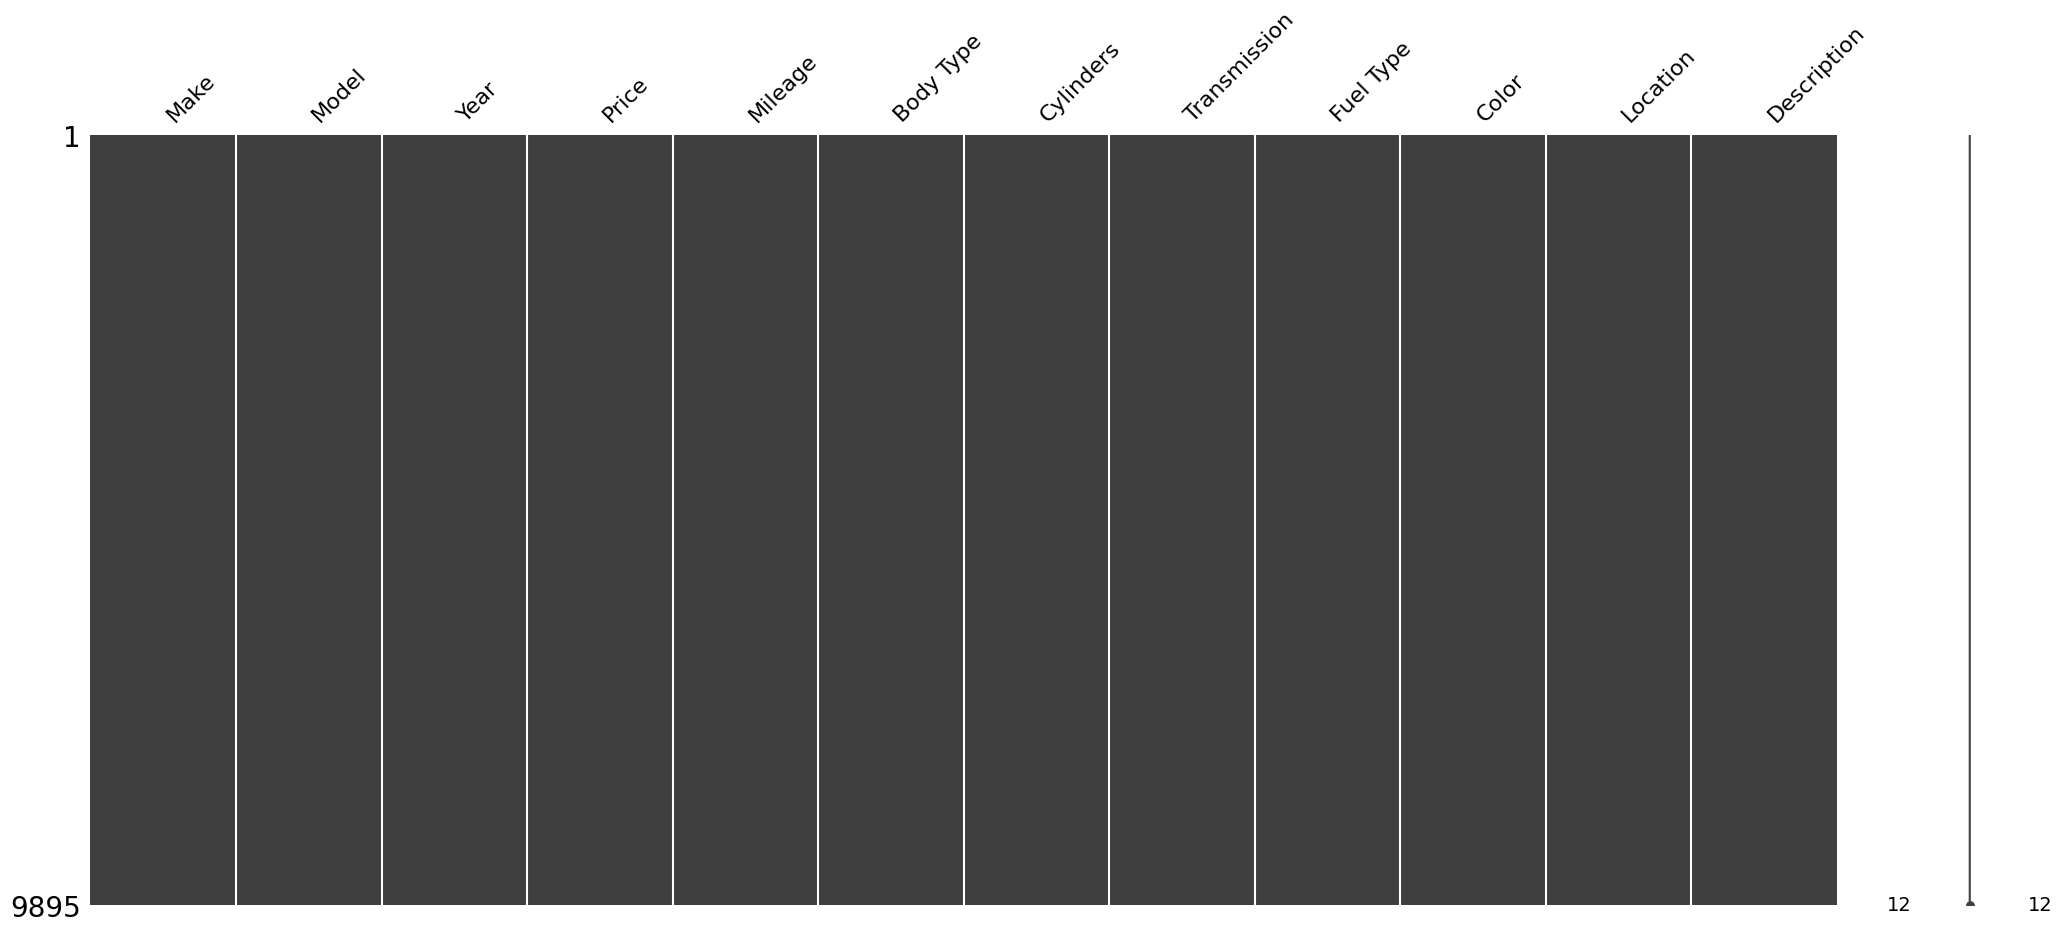

In [38]:
used_cars.dropna(inplace=True)
msno.matrix(used_cars)
plt.show()

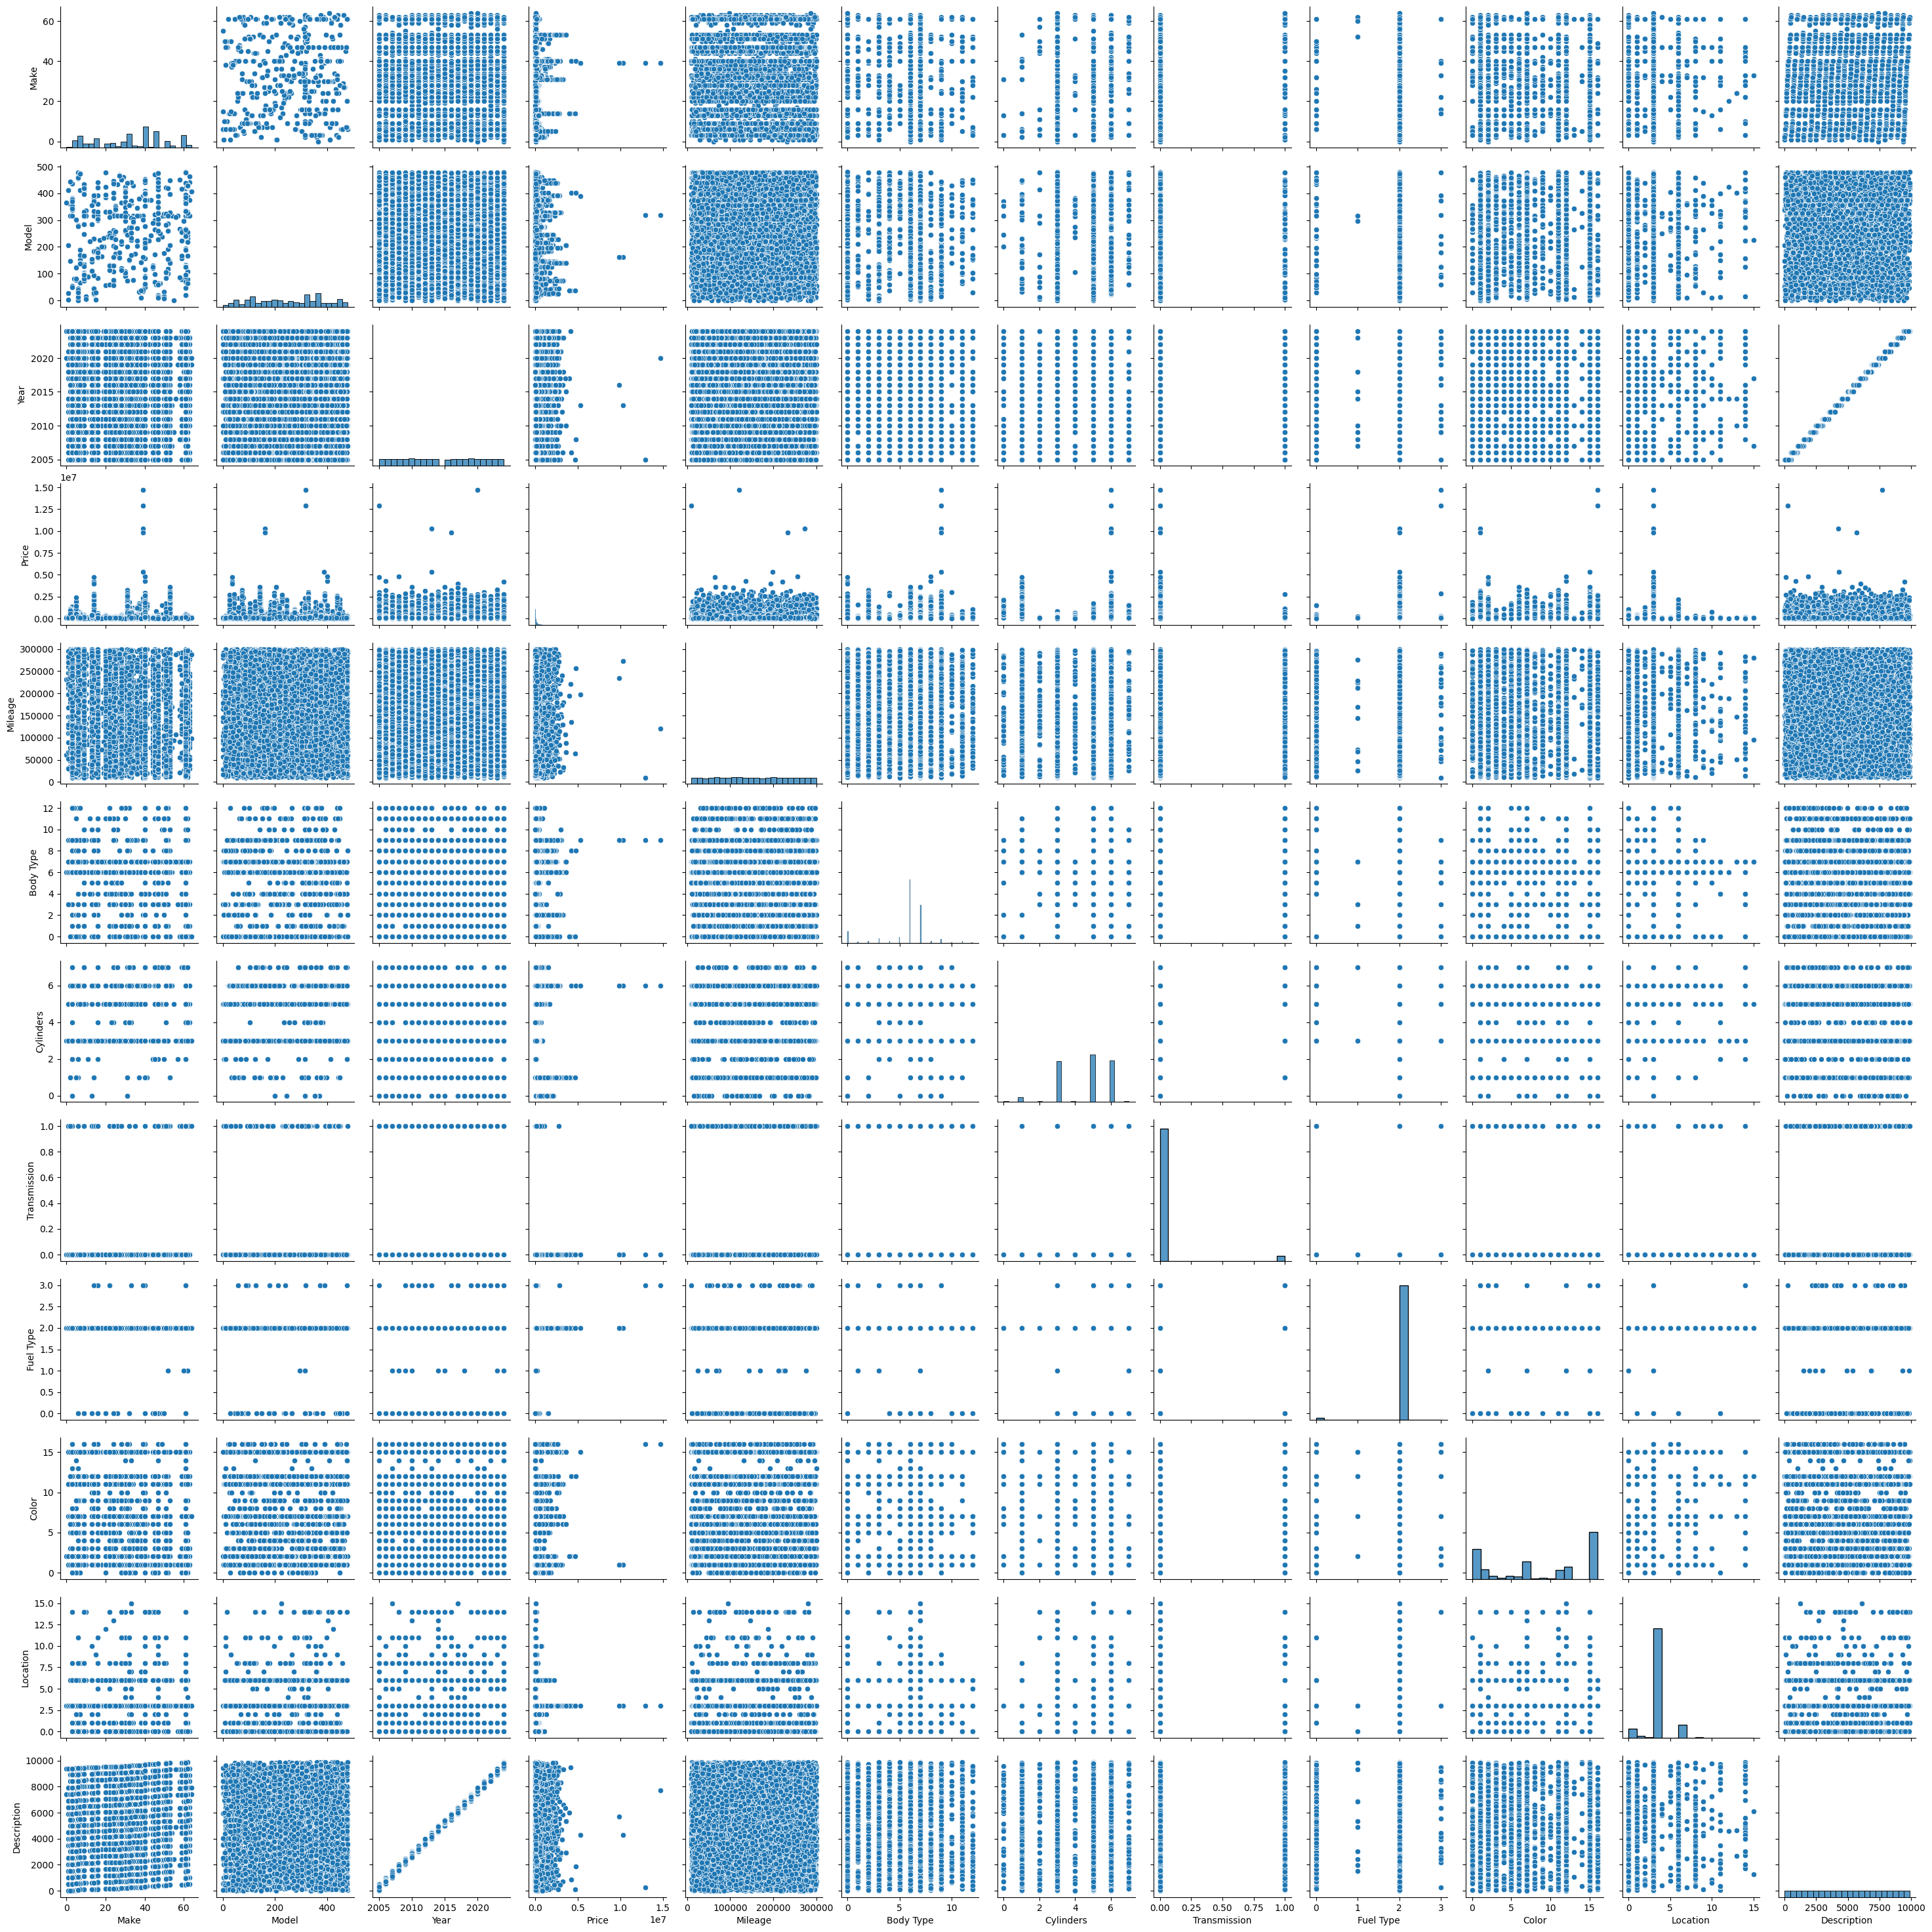

In [40]:
for column in used_cars.select_dtypes(include=['object']).columns:
    used_cars[column] = used_cars[column].astype('category').cat.codes

#pairplot plot
sns.pairplot(used_cars)
plt.show()

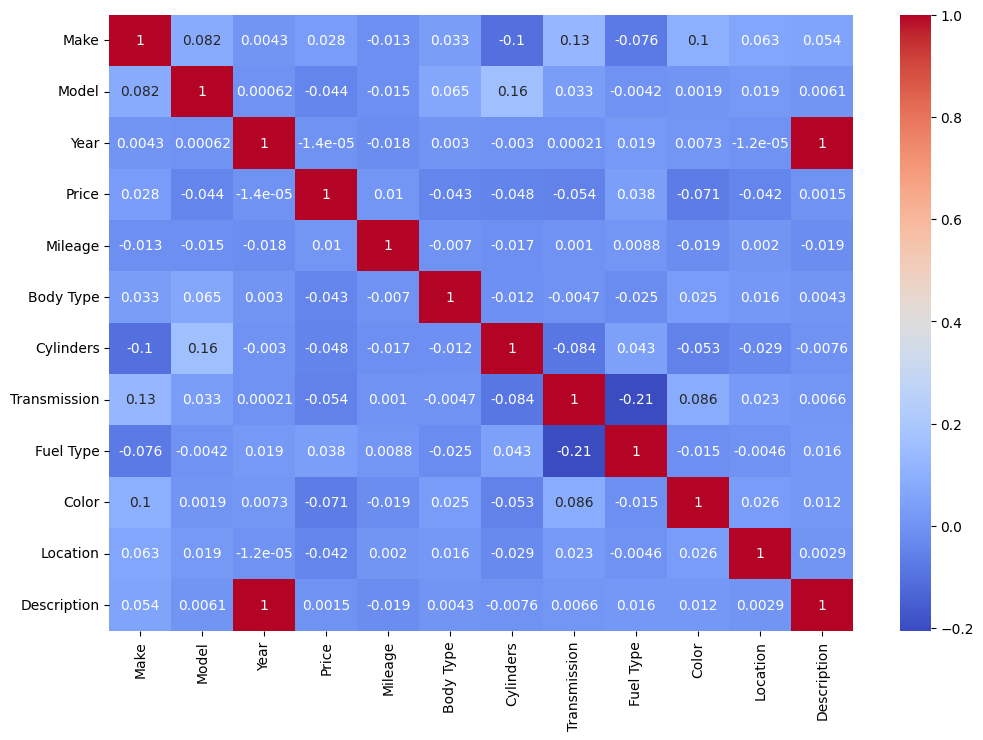

In [41]:
plt.figure(figsize=(12, 8))
sns.heatmap(used_cars.corr(), annot=True, cmap='coolwarm')
plt.show()

In [43]:
X = used_cars.drop('Price', axis=1)
y = used_cars['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [44]:
scaler = StandardScaler() #scale the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.decomposition import PCA
pca = PCA(n_components=2) #reduce the dimensionality
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#knn
knn_classifier = KNeighborsClassifier(n_neighbors=3, p=2, metric='minkowski')
knn_classifier.fit(X_train_pca, y_train)
y_pred_knn = knn_classifier.predict(X_test_pca)

In [47]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_pca, y_train)

# Get feature importances
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': used_cars.columns[:-1][indices],  # Exclude the target column
    'Importance': importances[indices]
})

# Display the DataFrame
print(feature_importances_df)

  Feature  Importance
0   Model     0.50004
1    Make     0.49996
